# Depth Pro Testing: Sharp Monocular Metric Depth
- Depth Pro: Sharp Monocular Metric Depth in Less Than a Second.: https://github.com/apple/ml-depth-pro
- Notebook repo: https://github.com/MichaelAkridge-NOAA/ml-depth-pro
- Notebook Contact: michael.akridge@noaa.gov

# 0. Install Depth Pro


In [ ]:
# clone repo
!git clone https://github.com/apple/ml-depth-pro.git
# install
%cd /content/ml-depth-pro
!pip install .

# Download the model weights into the 'checkpoints' directory
!mkdir -p /content/ml-depth-pro/checkpoints
!wget https://ml-site.cdn-apple.com/models/depth-pro/depth_pro.pt -P checkpoints

## Example

Using device: cuda


/usr/local/lib/python3.10/dist-packages/depth_pro/depth_pro.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(config.checkpoint_uri, map_location

Mean depth of the subject: 1.85 meters


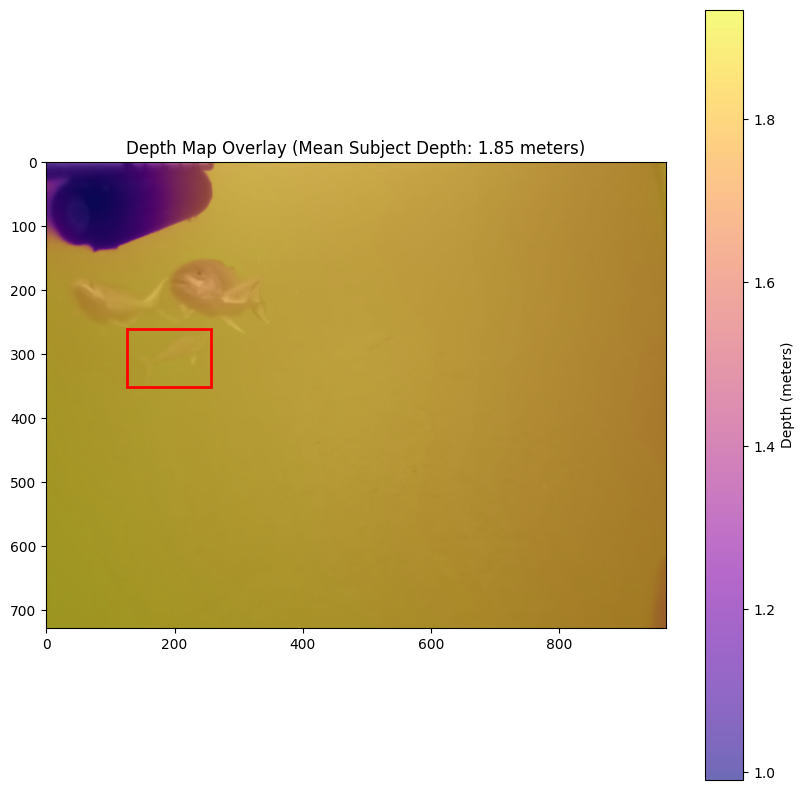

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import depth_pro

# Check if a GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model and preprocessing transform
model, transform = depth_pro.create_model_and_transforms()

# Move model to the GPU
model = model.to(device)
model.eval()

# Set the image path (make sure the image is uploaded or available in the environment)
image_path = '/content/00028.jpg'

# Load and preprocess the image
image, _, f_px = depth_pro.load_rgb(image_path)
image = transform(image)

# Move image to the GPU
image = image.to(device)

# Run inference
with torch.no_grad():  # Disable gradient calculation for inference
    prediction = model.infer(image, f_px=f_px)

# Extract depth in meters and focal length in pixels
depth = prediction["depth"].cpu()  # Move depth tensor back to CPU if necessary
focal_length_px = prediction["focallength_px"]  # Focal length stays on CPU

# Move the depth tensor back to CPU and convert to a NumPy array
depth_np = depth.squeeze().cpu().numpy()  # Remove any extra dimensions and move to CPU

# Load the original image (for overlay purposes)
original_image = Image.open(image_path)
original_image_np = np.array(original_image)

# Bounding box values (normalized to range 0-1)
# Format: (x_center, y_center, width, height)
bbox = [0.1981263594193892, 0.42186540037721065, 0.13521347361162675, 0.12527583195612982]

# Convert bounding box values to pixel coordinates
height, width = depth_np.shape
x_center, y_center, bbox_width, bbox_height = bbox

# Calculate bounding box in pixel coordinates
x_min = int((x_center - bbox_width / 2) * width)
x_max = int((x_center + bbox_width / 2) * width)
y_min = int((y_center - bbox_height / 2) * height)
y_max = int((y_center + bbox_height / 2) * height)

# Clip the coordinates to ensure they are within image bounds
x_min, x_max = np.clip([x_min, x_max], 0, width - 1)
y_min, y_max = np.clip([y_min, y_max], 0, height - 1)

# Extract the depth values within the bounding box
subject_depth_values = depth_np[y_min:y_max, x_min:x_max]

# Compute the mean depth value for the subject
mean_subject_depth = np.mean(subject_depth_values)
print(f"Mean depth of the subject: {mean_subject_depth:.2f} meters")

# Overlay the depth map on the original image
plt.figure(figsize=(10, 10))

# Display the original image
plt.imshow(original_image_np)

# Overlay the depth map with transparency (alpha)
plt.imshow(depth_np, cmap='plasma', alpha=0.6)  # Adjust alpha for transparency

# Add colorbar for the depth values
plt.colorbar(label='Depth (meters)')

# Draw the bounding box
rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, edgecolor='red', facecolor='none', linewidth=2)
plt.gca().add_patch(rect)

# Add a title and display the image
plt.title(f"Depth Map Overlay (Mean Subject Depth: {mean_subject_depth:.2f} meters)")
plt.show()


# Depth_Pro & YOLO 11

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import depth_pro

# Check if a GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model and preprocessing transform
model, transform = depth_pro.create_model_and_transforms()

# Move model to the GPU
model = model.to(device)
model.eval()

# Define paths
image_folder = '/content/images'  # Folder containing the image frames
label_folder = '/content/labels'  # Folder containing the YOLO labels
output_folder = '/content/output/overlays'  # Folder to save the depth map overlays
new_frames_folder = '/content/new_frames'  # Folder to save the frames for the video

# Ensure the output folders exist
os.makedirs(output_folder, exist_ok=True)
os.makedirs(new_frames_folder, exist_ok=True)

# Function to convert YOLO format to pixel coordinates
def yolo_to_pixel_coords(bbox, img_width, img_height):
    x_center, y_center, bbox_width, bbox_height = bbox
    x_min = int((x_center - bbox_width / 2) * img_width)
    x_max = int((x_center + bbox_width / 2) * img_width)
    y_min = int((y_center - bbox_height / 2) * img_height)
    y_max = int((y_center + bbox_height / 2) * img_height)
    return x_min, y_min, x_max, y_max

# Known ground truth distance for label ID 1
ground_truth_depth = 0.5  # 0.5 meters

# Specified default bounding box (in YOLO format) when ground truth is missing
default_bbox = [0.05114807336011826, 0.11712846347607055, 0.03409871557341217, 0.05037783375314861]

# Iterate over images and labels
for image_file in os.listdir(image_folder):
    if image_file.endswith(".jpg"):
        # Extract the image name without extension
        image_name = os.path.splitext(image_file)[0]

        # Load the image
        image_path = os.path.join(image_folder, image_file)
        image = Image.open(image_path)
        original_image_np = np.array(image)

        # Load the corresponding label file
        label_path = os.path.join(label_folder, f"{image_name}.txt")
        if not os.path.exists(label_path):
            print(f"Label file not found for {image_file}, skipping.")
            continue

        # Process the image with the depth model
        image_transformed, _, f_px = depth_pro.load_rgb(image_path)
        image_transformed = transform(image_transformed).to(device)

        with torch.no_grad():  # Disable gradient calculation for inference
            prediction = model.infer(image_transformed, f_px=f_px)

        # Extract depth map and focal length
        depth_map = prediction["depth"].cpu().numpy().squeeze()  # Move depth tensor to CPU

        # Get image dimensions
        img_height, img_width = depth_map.shape

        # Read the YOLO label and convert to pixel coordinates
        with open(label_path, 'r') as f:
            labels = f.readlines()

        # Store depths of objects for logging
        object_depths = []
        scaling_factor = None  # Scaling factor to adjust depth values
        ground_truth_found = False  # Flag to check if the ground truth box is found

        # First pass: Calculate scaling factor using the ground truth box
        for idx, label in enumerate(labels):
            class_id, x_center, y_center, bbox_width, bbox_height = map(float, label.split())
            x_min, y_min, x_max, y_max = yolo_to_pixel_coords((x_center, y_center, bbox_width, bbox_height), img_width, img_height)

            # Extract depth values within the bounding box
            object_depth_values = depth_map[y_min:y_max, x_min:x_max]
            mean_object_depth = np.mean(object_depth_values)

            # If class ID is 1, use the ground truth box to calculate the adjustment
            if class_id == 1:
                print(f"Ground truth box found with predicted depth: {mean_object_depth:.2f} meters")
                scaling_factor = ground_truth_depth / mean_object_depth  # Calculate scaling factor
                print(f"Scaling factor: {scaling_factor}")
                ground_truth_found = True
                break

        # If ground truth is missing, use the specified default bounding box for adjustment
        if not ground_truth_found:
            print("No ground truth box found, using specified default bounding box for adjustment.")
            x_min, y_min, x_max, y_max = yolo_to_pixel_coords(default_bbox, img_width, img_height)

            # Extract depth values within the default bounding box
            object_depth_values = depth_map[y_min:y_max, x_min:x_max]
            mean_object_depth = np.mean(object_depth_values)
            scaling_factor = ground_truth_depth / mean_object_depth  # Calculate scaling factor
            print(f"Default box predicted depth: {mean_object_depth:.2f} meters, Scaling factor: {scaling_factor}")

        # Second pass: Apply scaling factor to the entire depth map if needed
        if scaling_factor is not None:
            depth_map *= scaling_factor  # Adjust the depth map

        # Create and save the frame without the color bar
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.imshow(original_image_np)  # Show the original image
        ax.imshow(depth_map, cmap='plasma', alpha=0.6)  # Overlay the depth map with transparency

        # Draw bounding boxes and adjust depths (except for ground truth box)
        for idx, label in enumerate(labels):
            class_id, x_center, y_center, bbox_width, bbox_height = map(float, label.split())
            x_min, y_min, x_max, y_max = yolo_to_pixel_coords((x_center, y_center, bbox_width, bbox_height), img_width, img_height)

            # Skip drawing the ground truth bounding box
            if class_id == 1:
                continue  # Don't display the ground truth box on the overlay

            # Draw the bounding box
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, edgecolor='red', facecolor='none', linewidth=2)
            ax.add_patch(rect)
            # Annotate the mean depth on the image
            ax.text(x_min, y_min - 10, f'Depth: {mean_object_depth:.2f} m', color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

        # Save the frame (without the color bar)
        frame_path = os.path.join(new_frames_folder, f"{image_name}_frame.png")
        fig.savefig(frame_path, dpi=300, bbox_inches='tight', pad_inches=0)
        plt.close(fig)  # Close the figure to avoid memory leaks

        print(f"Processed and saved: {frame_path}")


Using device: cuda


/usr/local/lib/python3.10/dist-packages/depth_pro/depth_pro.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(config.checkpoint_uri, map_location

No ground truth box found, using specified default bounding box for adjustment.
Default box predicted depth: 1.30 meters, Scaling factor: 0.38368731731806455
Processed and saved: /content/new_frames/00031_frame.png
No ground truth box found, using specified default bounding box for adjustment.
Default box predicted depth: 1.08 meters, Scaling factor: 0.4627695555891703
Processed and saved: /content/new_frames/00027_frame.png
No ground truth box found, using specified default bounding box for adjustment.
Default box predicted depth: 1.54 meters, Scaling factor: 0.325469932024859
Processed and saved: /content/new_frames/00024_frame.png
No ground truth box found, using specified default bounding box for adjustment.
Default box predicted depth: 2.04 meters, Scaling factor: 0.24508065747908697
Processed and saved: /content/new_frames/00016_frame.png
No ground truth box found, using specified default bounding box for adjustment.
Default box predicted depth: 1.39 meters, Scaling factor: 0.359

In [ ]:
import shutil

# Function to create a zip file from a folder
def zip_folder(folder_path, output_zip_path):
    shutil.make_archive(output_zip_path, 'zip', folder_path)
    print(f"Zipped folder '{folder_path}' into '{output_zip_path}.zip'")

# Zip the folder containing the new frames
zip_filename = "/content/20241015new_frames_zip"  # Adjust path as needed
zip_folder(new_frames_folder, zip_filename)

# Provide a download link (if running in a Jupyter or Colab environment)
from google.colab import files
files.download(f"{zip_filename}.zip")


Zipped folder '/content/new_frames' into '/content/20241015new_frames_zip.zip'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 1. Run on Single Image

In [ ]:
import torch
from PIL import Image
import depth_pro

# Check if a GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model and preprocessing transform
model, transform = depth_pro.create_model_and_transforms()

# Move model to the GPU
model = model.to(device)
model.eval()

# Set the image path (make sure the image is uploaded or available in the environment)
image_path = '/content/00028.jpg'

# Load and preprocess the image
image, _, f_px = depth_pro.load_rgb(image_path)
image = transform(image)

# Move image to the GPU
image = image.to(device)

# Run inference
with torch.no_grad():  # Disable gradient calculation for inference
    prediction = model.infer(image, f_px=f_px)

# Extract depth in meters and focal length in pixels
depth = prediction["depth"].cpu()  # Move depth tensor back to CPU if necessary
focal_length_px = prediction["focallength_px"]  # Focal length stays on CPU

# Display results
print(f"Depth: {depth}")
print(f"Focal Length (px): {focal_length_px}")


Using device: cuda
Depth: tensor([[1.1760, 1.1517, 1.1297,  ..., 1.8562, 1.8589, 1.8783],
        [1.1322, 1.1213, 1.1129,  ..., 1.8424, 1.8481, 1.8443],
        [1.1116, 1.1062, 1.1026,  ..., 1.8374, 1.8407, 1.8489],
        ...,
        [1.9260, 1.9212, 1.9194,  ..., 1.7018, 1.7009, 1.6990],
        [1.9333, 1.9258, 1.9245,  ..., 1.7012, 1.6995, 1.6957],
        [1.9153, 1.9337, 1.9297,  ..., 1.6979, 1.6982, 1.7157]])
Focal Length (px): 1055.0758056640625


# 1a. Visualize Image

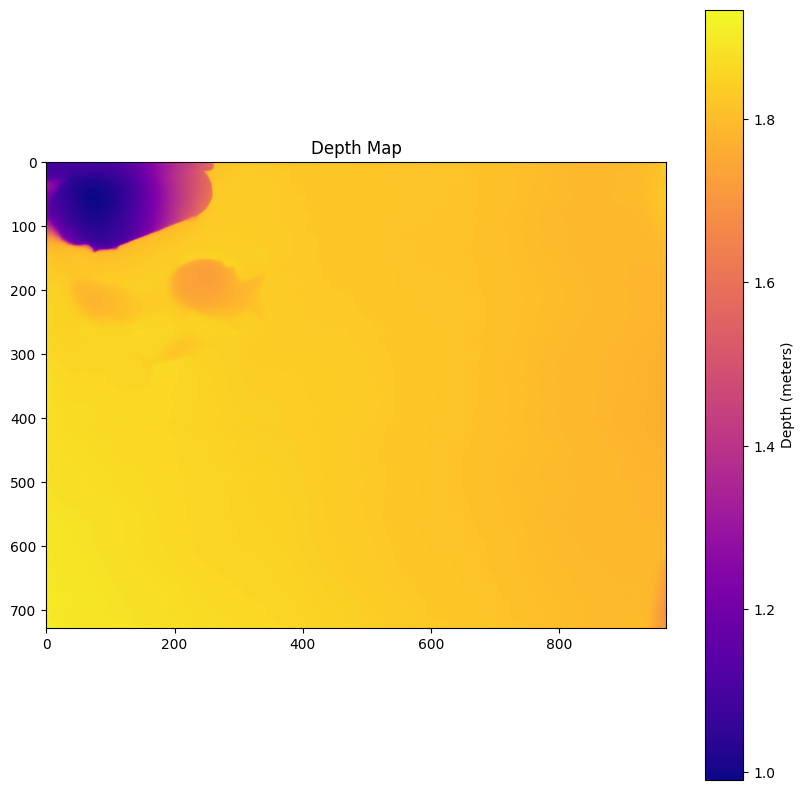

In [ ]:
import matplotlib.pyplot as plt
import torch

# Move the depth tensor back to CPU if necessary and convert to a NumPy array
depth_np = depth.squeeze().cpu().numpy()  # Remove any extra dimensions and move to CPU

# Display the depth map
plt.figure(figsize=(10, 10))
plt.imshow(depth_np, cmap='plasma')  # Use a color map like 'plasma' for better visualization
plt.colorbar(label='Depth (meters)')  # Add a colorbar to represent depth values
plt.title("Depth Map")
plt.show()


In [ ]:
import torch
from PIL import Image
import depth_pro
import numpy as np
import open3d as o3d
import os

# Check if a GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model and preprocessing transform
model, transform = depth_pro.create_model_and_transforms()

# Move model to the GPU
model = model.to(device)
model.eval()

# Set the image path (make sure the image is uploaded or available in the environment)
image_path = '/content/00028.jpg'

# Load and preprocess the image
image, _, f_px = depth_pro.load_rgb(image_path)
image = transform(image)

# Move image to the GPU
image = image.to(device)

# Run inference
with torch.no_grad():  # Disable gradient calculation for inference
    prediction = model.infer(image, f_px=f_px)

# Extract depth in meters and focal length in pixels
depth = prediction["depth"].cpu().numpy()  # Move depth tensor back to CPU if necessary and convert to numpy
focal_length_px = prediction["focallength_px"]  # Focal length stays on CPU

# Save depth map as .npz for visualization
output_depth_path = 'output/depth.npz'
os.makedirs(os.path.dirname(output_depth_path), exist_ok=True)
np.savez(output_depth_path, depth=depth)

# Load the RGB image for visualization (convert to numpy array)
img_pil = Image.open(image_path).convert("RGB")
image_rgb = np.array(img_pil)

# Visualize depth map using Open3D
def visualize_depth_with_open3d(depth, image_rgb, focal_length=1500.0):
    # Convert numpy arrays to Open3D Image objects
    color_image = o3d.geometry.Image(image_rgb)
    depth_image = o3d.geometry.Image(depth)

    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color_image, depth_image,
        depth_scale=1.0,  # Adjust this value based on your depth scale
        depth_trunc=100.0,  # Adjust this value based on your depth range
        convert_rgb_to_intensity=False
    )

    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd,
        o3d.camera.PinholeCameraIntrinsic(
            width=depth.shape[1],
            height=depth.shape[0],
            fx=focal_length,
            fy=focal_length,
            cx=depth.shape[1] / 2,
            cy=depth.shape[0] / 2
        )
    )

    # flip the orientation, so it looks upright, not upside-down
    pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

    # Create coordinate frame
    coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
    # Visualize the point cloud with coordinate frame
    o3d.visualization.draw_geometries([pcd, coordinate_frame], point_show_normal=True)

# Call the visualization function
visualize_depth_with_open3d(depth, image_rgb, focal_length=focal_length_px)

print(f"Depth: {depth}")
print(f"Focal Length (px): {focal_length_px}")


Using device: cuda


/usr/local/lib/python3.10/dist-packages/depth_pro/depth_pro.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(config.checkpoint_uri, map_location

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
Depth: [[1.1759652 1.1516776 1.1296926 ... 1.8562039 1.8589482 1.8783393]
 [1.1322395 1.1213138 1.112904  ... 1.8424481 1.848072  1.8443396]
 [1.1115774 1.1061848 1.1025928 ... 1.8373892 1.8406906 1.8488643]
 ...
 [1.9259905 1.9212188 1.9194297 ... 1.7018491 1.7008811 1.6989536]
 [1.9333    1.9257985 1.9244515 ... 1.7011966 1.6995467 1.6956985]
 [1.9153152 1.9337245 1.9297134 ... 1.6978766 1.69818   1.7156585]]
Focal Length (px): 1055.0758056640625


In [ ]:
import plotly.graph_objects as go

# Create a meshgrid from depth data for visualization
x = np.linspace(0, depth.shape[1] - 1, depth.shape[1])
y = np.linspace(0, depth.shape[0] - 1, depth.shape[0])
x, y = np.meshgrid(x, y)

# Plot depth as a 3D surface
fig = go.Figure(data=[go.Surface(z=depth, x=x, y=y)])
fig.update_layout(
    title='Depth Map',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Depth'
    ),
    margin=dict(l=0, r=0, b=0, t=50)
)
fig.show()


In [ ]:


import numpy as np
from PIL import Image
import open3d as o3d
import os
from pyvirtualdisplay import Display
import plotly.graph_objects as go

# Start a virtual display for Open3D to work in Google Colab
display = Display(visible=0, size=(800, 600))
display.start()

# Set the image and depth map paths
image_path = '/content/00028.jpg'
depth_path = '/content/output/depth.npz'

# Load depth map from .npz file
depth_data = np.load(depth_path)
depth = depth_data['depth']

# Load the RGB image for visualization (convert to numpy array)
img_pil = Image.open(image_path).convert("RGB")
image_rgb = np.array(img_pil)

# Create a meshgrid from depth data for visualization
x = np.linspace(0, depth.shape[1] - 1, depth.shape[1])
y = np.linspace(0, depth.shape[0] - 1, depth.shape[0])
x, y = np.meshgrid(x, y)

# Normalize the RGB image to a range [0, 1] for use with Plotly
image_rgb_normalized = image_rgb / 255.0

# Create a combined RGB color string for each pixel
colorscale = [
    f"rgb({int(r * 255)}, {int(g * 255)}, {int(b * 255)})"
    for r, g, b in image_rgb_normalized.reshape(-1, 3)
]

# Plot depth as a 3D surface with RGB image as the color scale
fig = go.Figure(data=[go.Surface(
    z=depth,
    x=x,
    y=y,
    surfacecolor=image_rgb_normalized[..., 0],  # Use R channel for color scale
    colorscale='Viridis',
    cmin=0,
    cmax=1,
    showscale=False  # Hide the default scale to focus on the RGB image overlay
)])

fig.update_layout(
    title='Depth Map with RGB Overlay',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Depth'
    ),
    margin=dict(l=0, r=0, b=0, t=50)
)

fig.show()

In [ ]:
# Install required packages
!pip install open3d plotly pyvirtualdisplay
!apt-get install -y xvfb

import torch
from PIL import Image
import depth_pro
import numpy as np
import open3d as o3d
import os
from pyvirtualdisplay import Display
import plotly.graph_objects as go

# Start a virtual display for Open3D to work in Google Colab
display = Display(visible=0, size=(800, 600))
display.start()

# Check if a GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model and preprocessing transform
model, transform = depth_pro.create_model_and_transforms()

# Move model to the GPU
model = model.to(device)
model.eval()

# Set the image path (make sure the image is uploaded or available in the environment)
image_path = '/content/00028.jpg'

# Load and preprocess the image
image, _, f_px = depth_pro.load_rgb(image_path)
image = transform(image)

# Move image to the GPU
image = image.to(device)

# Run inference
with torch.no_grad():  # Disable gradient calculation for inference
    prediction = model.infer(image, f_px=f_px)

# Extract depth in meters and focal length in pixels
depth = prediction["depth"].cpu().numpy()  # Move depth tensor back to CPU and convert to numpy
focal_length_px = prediction["focallength_px"]  # Focal length stays on CPU

# Save depth map as .npz for visualization
output_depth_path = 'output/depth.npz'
os.makedirs(os.path.dirname(output_depth_path), exist_ok=True)
np.savez(output_depth_path, depth=depth)

# Load the RGB image for visualization (convert to numpy array)
img_pil = Image.open(image_path).convert("RGB")
image_rgb = np.array(img_pil)

# Create a meshgrid from depth data for visualization
x = np.linspace(0, depth.shape[1] - 1, depth.shape[1])
y = np.linspace(0, depth.shape[0] - 1, depth.shape[0])
x, y = np.meshgrid(x, y)

# Normalize the RGB image to a range [0, 1] for use with Plotly
image_rgb_normalized = image_rgb / 255.0

# Create a combined RGB color string for each pixel
colorscale = [
    f"rgb({int(r * 255)}, {int(g * 255)}, {int(b * 255)})"
    for r, g, b in image_rgb_normalized.reshape(-1, 3)
]

# Plot depth as a 3D surface with RGB image as the color scale
fig = go.Figure(data=[go.Surface(
    z=depth,
    x=x,
    y=y,
    surfacecolor=np.linspace(0, 1, len(colorscale)).reshape(depth.shape),  # Arbitrary scaling of surface colors
    colorscale=colorscale,
    cmin=0,
    cmax=1,
    showscale=False  # Hide the default scale to focus on the RGB image overlay
)])

fig.update_layout(
    title='Depth Map with RGB Overlay',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Depth'
    ),
    margin=dict(l=0, r=0, b=0, t=50)
)

fig.show()

In [ ]:
# Install required packages
!pip install open3d plotly pyvirtualdisplay
!apt-get install -y xvfb

import numpy as np
from PIL import Image
import open3d as o3d
import os
from pyvirtualdisplay import Display
import plotly.graph_objects as go

# Start a virtual display for Open3D to work in Google Colab
display = Display(visible=0, size=(800, 600))
display.start()

# Set the image and depth map paths
image_path = '/content/00028.jpg'
depth_path = 'output/depth.npz'

# Load depth map from .npz file
depth_data = np.load(depth_path)
depth = depth_data['depth']

# Load the RGB image for visualization (convert to numpy array)
img_pil = Image.open(image_path).convert("RGB")
image_rgb = np.array(img_pil)

# Create a meshgrid from depth data for visualization
x = np.linspace(0, depth.shape[1] - 1, depth.shape[1])
y = np.linspace(0, depth.shape[0] - 1, depth.shape[0])
x, y = np.meshgrid(x, y)

# Normalize the RGB image to a range [0, 1] for use with Plotly
image_rgb_normalized = image_rgb / 255.0

# Create a combined RGB color string for each pixel
colorscale = [
    f"rgb({int(r * 255)}, {int(g * 255)}, {int(b * 255)})"
    for r, g, b in image_rgb_normalized.reshape(-1, 3)
]

# Plot depth as a 3D surface with RGB image as the color scale
fig = go.Figure(data=[go.Surface(
    z=depth,
    x=x,
    y=y,
    surfacecolor=np.linspace(0, 1, len(colorscale)).reshape(depth.shape),  # Arbitrary scaling of surface colors
    colorscale=colorscale,
    cmin=0,
    cmax=1,
    showscale=False  # Hide the default scale to focus on the RGB image overlay
)])

fig.update_layout(
    title='Depth Map with RGB Overlay',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Depth'
    ),
    margin=dict(l=0, r=0, b=0, t=50)
)

fig.show()

In [ ]:
# Install necessary packages
!apt-get install -y xvfb
!pip install pyvirtualdisplay
!pip install open3d plotly

import torch
from PIL import Image
import depth_pro
import numpy as np
import open3d as o3d
import os
from pyvirtualdisplay import Display
import plotly.graph_objects as go

# Start virtual display for Open3D visualization
display = Display(visible=0, size=(800, 600))
display.start()

# Check if a GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model and preprocessing transform
model, transform = depth_pro.create_model_and_transforms()

# Move model to the GPU
model = model.to(device)
model.eval()

# Set the image path (make sure the image is uploaded or available in the environment)
image_path = '/content/00028.jpg'

# Load and preprocess the image
image, _, f_px = depth_pro.load_rgb(image_path)
image = transform(image)

# Move image to the GPU
image = image.to(device)

# Run inference
with torch.no_grad():  # Disable gradient calculation for inference
    prediction = model.infer(image, f_px=f_px)

# Extract depth in meters and focal length in pixels
depth = prediction["depth"]  # Keep depth tensor on GPU if possible
focal_length_px = prediction["focallength_px"]  # Focal length stays on GPU

# Save depth map as .npz for visualization
output_depth_path = 'output/depth.npz'
os.makedirs(os.path.dirname(output_depth_path), exist_ok=True)
np.savez(output_depth_path, depth=depth.cpu().numpy())

# Load the RGB image for visualization (convert to numpy array)
img_pil = Image.open(image_path).convert("RGB")
image_rgb = np.array(img_pil)

# Visualize depth map using Open3D
def visualize_depth_with_open3d(depth, image_rgb, focal_length=1500.0):
    # Convert numpy arrays to Open3D Image objects
    color_image = o3d.geometry.Image(image_rgb)
    depth_image = o3d.geometry.Image(depth.cpu().numpy())

    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color_image, depth_image,
        depth_scale=1.0,  # Adjust this value based on your depth scale
        depth_trunc=100.0,  # Adjust this value based on your depth range
        convert_rgb_to_intensity=False
    )

    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd,
        o3d.camera.PinholeCameraIntrinsic(
            width=depth.shape[2],
            height=depth.shape[1],
            fx=focal_length,
            fy=focal_length,
            cx=depth.shape[2] / 2,
            cy=depth.shape[1] / 2
        )
    )

    # flip the orientation, so it looks upright, not upside-down
    pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

    # Create coordinate frame
    coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])
    # Visualize the point cloud with coordinate frame
    o3d.visualization.draw_geometries([pcd, coordinate_frame], point_show_normal=True)

# Call the visualization function
visualize_depth_with_open3d(depth, image_rgb, focal_length=focal_length_px)

# Alternative visualization using Plotly (if Open3D fails due to environment limitations)
x = np.linspace(0, depth.shape[2] - 1, depth.shape[2])
y = np.linspace(0, depth.shape[1] - 1, depth.shape[1])
x, y = np.meshgrid(x, y)

fig = go.Figure(data=[go.Surface(z=depth.cpu().numpy(), x=x, y=y)])
fig.update_layout(
    title='Depth Map',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Depth'
    ),
    margin=dict(l=0, r=0, b=0, t=50)
)
fig.show()

print(f"Depth: {depth}")
print(f"Focal Length (px): {focal_length_px}")

# 2. Run on Video - Setup
- Run install at top of notebook
- install for video processing

In [ ]:
# install for video processing
!pip install opencv-python
!apt-get install ffmpeg

# 2.a Extract Video Frames

In [ ]:
!mkdir frames  # Create a folder to store the frames
!ffmpeg -i /content/2024dvr_test_vid_clip_Trim.mp4 frames/frame_%04d.png  # Extract frames into 'frames' directory
import torch
import cv2
import os
import numpy as np
from PIL import Image
import depth_pro
from google.colab import files

# Initialize the depth model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, transform = depth_pro.create_model_and_transforms()
model = model.to(device)
model.eval()

# Create an output folder for processed frames
os.makedirs('processed_frames', exist_ok=True)

# Folder where frames are stored
frame_folder = 'frames'

# Process each extracted frame
frame_files = sorted(os.listdir(frame_folder))
for frame_file in frame_files:
    frame_path = os.path.join(frame_folder, frame_file)

    # Load the frame
    frame = cv2.imread(frame_path)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(rgb_frame)

    # Preprocess and run inference
    pil_image = transform(pil_image).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model.infer(pil_image)

    # Extract depth
    depth_map = prediction['depth'].squeeze().cpu().numpy()

    # Normalize depth map for visualization
    depth_map_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    depth_map_normalized = np.uint8(depth_map_normalized)

    # Convert grayscale depth map to color
    depth_bgr = cv2.applyColorMap(depth_map_normalized, cv2.COLORMAP_PLASMA)

    # Save the processed frame
    processed_frame_path = os.path.join('processed_frames', frame_file)
    cv2.imwrite(processed_frame_path, depth_bgr)

# Use ffmpeg to combine the frames into a video
!ffmpeg -framerate 24 -i processed_frames/frame_%04d.png -c:v libx264 -pix_fmt yuv420p output_video.mp4

# Download the output video
files.download('output_video.mp4')


# 2.b Run Model on Frames & Download Processed Video

In [ ]:
import torch
import cv2
import os
import numpy as np
from PIL import Image
import depth_pro
from google.colab import files

# Initialize the depth model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, transform = depth_pro.create_model_and_transforms()
model = model.to(device)
model.eval()

# Create an output folder for processed frames
os.makedirs('processed_frames', exist_ok=True)

# Folder where frames are stored
frame_folder = 'frames'

# Process each extracted frame
frame_files = sorted(os.listdir(frame_folder))
for frame_file in frame_files:
    frame_path = os.path.join(frame_folder, frame_file)

    # Load the frame
    frame = cv2.imread(frame_path)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(rgb_frame)

    # Preprocess and run inference
    pil_image = transform(pil_image).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model.infer(pil_image)

    # Extract depth
    depth_map = prediction['depth'].squeeze().cpu().numpy()

    # Normalize depth map for visualization
    depth_map_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    depth_map_normalized = np.uint8(depth_map_normalized)

    # Convert grayscale depth map to color
    depth_bgr = cv2.applyColorMap(depth_map_normalized, cv2.COLORMAP_PLASMA)

    # Save the processed frame
    processed_frame_path = os.path.join('processed_frames', frame_file)
    cv2.imwrite(processed_frame_path, depth_bgr)

# Use ffmpeg to combine the frames into a video
!ffmpeg -framerate 24 -i processed_frames/frame_%04d.png -c:v libx264 -pix_fmt yuv420p output_video.mp4

# Download the output video
files.download('output_video.mp4')


# 3. (optional) Download Processed Frames

In [ ]:
!mkdir frames  # Create a folder to store the frames
!ffmpeg -i /content/2024dvr_test_vid_clip_Trim.mp4 frames/frame_%04d.png  # Extract frames into 'frames' directory
import torch
import cv2
import os
import numpy as np
from PIL import Image
import depth_pro
from google.colab import files

# Initialize the depth model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, transform = depth_pro.create_model_and_transforms()
model = model.to(device)
model.eval()

# Create an output folder for processed frames
os.makedirs('processed_frames', exist_ok=True)

# Folder where frames are stored
frame_folder = 'frames'

# Process each extracted frame
frame_files = sorted(os.listdir(frame_folder))
for frame_file in frame_files:
    frame_path = os.path.join(frame_folder, frame_file)

    # Load the frame
    frame = cv2.imread(frame_path)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(rgb_frame)

    # Preprocess and run inference
    pil_image = transform(pil_image).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model.infer(pil_image)

    # Extract depth
    depth_map = prediction['depth'].squeeze().cpu().numpy()

    # Normalize depth map for visualization
    depth_map_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    depth_map_normalized = np.uint8(depth_map_normalized)

    # Convert grayscale depth map to color
    depth_bgr = cv2.applyColorMap(depth_map_normalized, cv2.COLORMAP_PLASMA)

    # Save the processed frame
    processed_frame_path = os.path.join('processed_frames', frame_file)
    cv2.imwrite(processed_frame_path, depth_bgr)

# Use ffmpeg to combine the frames into a video
!ffmpeg -framerate 24 -i processed_frames/frame_%04d.png -c:v libx264 -pix_fmt yuv420p output_video.mp4

# Download the output video
files.download('output_video.mp4')


import shutil
from google.colab import files

# Zip the 'processed_frames' directory
shutil.make_archive('processed_frames', 'zip', 'processed_frames')

# Download the zip file
files.download('processed_frames.zip')
!ffmpeg -i /content/output_video.mp4 -vf "scale=iw*0.75:ih*0.75" /content/output_video.gif

# 4. (optional) Create Gif of Video

In [ ]:
!ffmpeg -i /content/output_video.mp4 -vf "scale=iw*0.75:ih*0.75" /content/output_video.gif


# View Depth in 3D

In [ ]:
# Install required packages
!pip install open3d plotly pyvirtualdisplay rasterio
!apt-get install -y xvfb ffmpeg
!pip install open3d

import torch
import cv2
import os
import numpy as np
from PIL import Image
import depth_pro
import shutil
from google.colab import files
from pyvirtualdisplay import Display

# Start a virtual display for Open3D to work in Google Colab
display = Display(visible=0, size=(800, 600))
display.start()

# Create a folder to store the frames
os.makedirs('frames', exist_ok=True)

# Upload video for batch processing
uploaded_video = files.upload()

if '2024dvr_test_vid_clip_Trim.mp4' in uploaded_video:
    os.system("ffmpeg -i 2024dvr_test_vid_clip_Trim.mp4 frames/frame_%04d.png")  # Extract frames into 'frames' directory

    # Initialize the depth model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model, transform = depth_pro.create_model_and_transforms()
    model = model.to(device)
    model.eval()

    # Create an output folder for processed frames
    os.makedirs('processed_frames', exist_ok=True)

    # Folder where frames are stored
    frame_folder = 'frames'

    # Process each extracted frame
    frame_files = sorted(os.listdir(frame_folder))
    for frame_file in frame_files:
        frame_path = os.path.join(frame_folder, frame_file)

        # Load the frame
        frame = cv2.imread(frame_path)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(rgb_frame)

        # Preprocess and run inference
        pil_image = transform(pil_image).unsqueeze(0).to(device)
        with torch.no_grad():
            prediction = model.infer(pil_image)

        # Extract depth
        depth_map = prediction['depth'].squeeze().cpu().numpy()

        # Save depth map as .npz
        npz_filename = os.path.join('processed_frames', f"{os.path.splitext(frame_file)[0]}_depth.npz")
        np.savez(npz_filename, depth=depth_map)

        # Normalize depth map for visualization
        depth_map_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
        depth_map_normalized = np.uint8(depth_map_normalized)

        # Convert grayscale depth map to color
        depth_bgr = cv2.applyColorMap(depth_map_normalized, cv2.COLORMAP_PLASMA)

        # Save the processed frame
        processed_frame_path = os.path.join('processed_frames', frame_file)
        cv2.imwrite(processed_frame_path, depth_bgr)

    # Use ffmpeg to combine the frames into a video
    os.system("ffmpeg -framerate 24 -i processed_frames/frame_%04d.png -c:v libx264 -pix_fmt yuv420p output_video.mp4")

    # Download the output video
    files.download('output_video.mp4')

    # Zip the 'processed_frames' directory
    shutil.make_archive('processed_frames', 'zip', 'processed_frames')

    # Download the zip file
    files.download('processed_frames.zip')

# Process With Offsets and Objects

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import depth_pro

# Check if a GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model and preprocessing transform
model, transform = depth_pro.create_model_and_transforms()

# Move model to the GPU
model = model.to(device)
model.eval()

# Define paths
image_folder = '/content/images'  # Folder containing the image frames
label_folder = '/content/labels'  # Folder containing the YOLO labels
output_folder = '/content/output/overlays'  # Folder to save the depth map overlays
npz_output_folder = '/content/output/npz_files'  # Folder to save the .npz files

# Ensure the output folders exist
os.makedirs(output_folder, exist_ok=True)
os.makedirs(npz_output_folder, exist_ok=True)

# Function to convert YOLO format to pixel coordinates
def yolo_to_pixel_coords(bbox, img_width, img_height):
    x_center, y_center, bbox_width, bbox_height = bbox
    x_min = int((x_center - bbox_width / 2) * img_width)
    x_max = int((x_center + bbox_width / 2) * img_width)
    y_min = int((y_center - bbox_height / 2) * img_height)
    y_max = int((y_center + bbox_height / 2) * img_height)
    return x_min, y_min, x_max, y_max

# Known ground truth distance for label ID 1
ground_truth_depth = 0.5  # 0.5 meters

# Iterate over images and labels
for image_file in os.listdir(image_folder):
    if image_file.endswith(".jpg"):
        # Extract the image name without extension
        image_name = os.path.splitext(image_file)[0]

        # Load the image
        image_path = os.path.join(image_folder, image_file)
        image = Image.open(image_path)
        original_image_np = np.array(image)

        # Load the corresponding label file
        label_path = os.path.join(label_folder, f"{image_name}.txt")
        if not os.path.exists(label_path):
            print(f"Label file not found for {image_file}, skipping.")
            continue

        # Process the image with the depth model
        image_transformed, _, f_px = depth_pro.load_rgb(image_path)
        image_transformed = transform(image_transformed).to(device)

        with torch.no_grad():  # Disable gradient calculation for inference
            prediction = model.infer(image_transformed, f_px=f_px)

        # Extract depth map and focal length
        depth_map = prediction["depth"].cpu().numpy().squeeze()  # Move depth tensor to CPU
        focal_length_px = prediction['focallength_px'].cpu().numpy()  # Move focal length tensor to CPU

        # Get image dimensions
        img_height, img_width = depth_map.shape

        # Read the YOLO label and convert to pixel coordinates
        with open(label_path, 'r') as f:
            labels = f.readlines()

        # Store depths of objects for logging
        object_depths = []
        scaling_factor = None  # Scaling factor to adjust depth values

        # First pass: Calculate scaling factor using the ground truth box
        for idx, label in enumerate(labels):
            class_id, x_center, y_center, bbox_width, bbox_height = map(float, label.split())
            x_min, y_min, x_max, y_max = yolo_to_pixel_coords((x_center, y_center, bbox_width, bbox_height), img_width, img_height)

            # Extract depth values within the bounding box
            object_depth_values = depth_map[y_min:y_max, x_min:x_max]
            mean_object_depth = np.mean(object_depth_values)

            # If class ID is 1, use the ground truth box to calculate the adjustment
            if class_id == 1:
                print(f"Ground truth box found with predicted depth: {mean_object_depth:.2f} meters")
                scaling_factor = ground_truth_depth / mean_object_depth  # Calculate scaling factor
                print(f"Scaling factor: {scaling_factor}")
                break

        # Second pass: Apply scaling factor to the entire depth map if needed
        if scaling_factor is not None:
            depth_map *= scaling_factor  # Adjust the depth map

        # Save adjusted depth map and focal length as .npz
        npz_filename = os.path.join(npz_output_folder, f"{image_name}_depth.npz")
        np.savez(npz_filename, depth=depth_map, focal_length=focal_length_px)

        # Overlay the depth map on the original image
        plt.figure(figsize=(10, 10))
        plt.imshow(original_image_np)  # Show the original image
        plt.imshow(depth_map, cmap='plasma', alpha=0.6)  # Overlay the depth map with transparency

        # Add colorbar for the depth values
        plt.colorbar(label='Depth (meters)')

        # Draw bounding boxes and adjust depths
        for idx, label in enumerate(labels):
            class_id, x_center, y_center, bbox_width, bbox_height = map(float, label.split())
            x_min, y_min, x_max, y_max = yolo_to_pixel_coords((x_center, y_center, bbox_width, bbox_height), img_width, img_height)

            # Extract depth values within the bounding box
            object_depth_values = depth_map[y_min:y_max, x_min:x_max]
            mean_object_depth = np.mean(object_depth_values)
            object_depths.append((idx, mean_object_depth))
            print(f"Object {idx}: Mean Depth = {mean_object_depth:.2f} meters")

            # Draw the bounding box
            rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, edgecolor='red', facecolor='none', linewidth=2)
            plt.gca().add_patch(rect)
            # Annotate the mean depth on the image
            plt.text(x_min, y_min - 10, f'Depth: {mean_object_depth:.2f} m', color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

        # Add a title
        plt.title(f"Depth Map Overlay for {image_name}")

        # Save the plot as an image file
        output_image_path = os.path.join(output_folder, f"{image_name}_depth_overlay.png")
        plt.savefig(output_image_path, dpi=300)  # Save with high resolution
        plt.close()  # Close the figure to avoid display overhead

        print(f"Processed and saved: {output_image_path} and {npz_filename}")